In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [187]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy(dtype=np.int64)

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy(dtype=np.int64)

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy(dtype=np.int64)

In [188]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

In [189]:
def gini(sequence):
    if len(sequence) != 0:
        n_samples = sequence.shape[0] 
        _, counts = np.unique(sequence, return_counts=True)
        freq = counts / n_samples
        gini_index = 1 - np.power(freq,2).sum()
    else:
        gini_index = 0
    return gini_index


def entropy(sequence):
    if len(sequence) != 0:
        n_samples = sequence.shape[0]
        _, counts = np.unique(sequence, return_counts=True)
        freq = counts / n_samples
        entropy = -np.dot(freq,np.log2(freq))
    else:
        entropy = 0
    return entropy


In [190]:
class Tree():
    """
    Tree 就是 Node
    如果是 leaf -> 僅包含這個 node 屬於哪個 label, 意味著如果 testing data 被分到這裡就是預測為這個類別
    如果不是 leaf -> 會包含這個 node 的左右 child node, 以及這個 node 是用哪個特徵把資料分開，然後分開的 threshold
    """
    def __init__(self, feature=None, feature_threshold=None, left=None, right=None, * , value=None):
        self.feature = feature
        self.feature_threshold = feature_threshold
        self.left = left
        self.right = right
        self.value = value
    def is_leaf(self):
        return self.value is not None

In [191]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=3, max_features=None):

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth
        # 指定要用幾個 feature 去 train
        self.max_features = max_features
        self.importance = []
    
    def fit(self, X, y):
        self.max_features = X.shape[1] if self.max_features is None else int(self.max_features)
        self.root = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        if n_samples == 0: # (?)假設一個 node 有三筆 data, unique label > 1, 
            # 剛好用的 feautre 又篩不出來，選到的 best feature 會讓 data 被分到左子點 or 右子點, 這樣另外一個子點就會沒有資料
            return None
        if (depth >= self.max_depth or n_labels == 1):
            # 走到這一步就是要確定 leaf node 被定義成哪個類
            unique_val, counts = np.unique(y, return_counts = True)
            leaf_label = unique_val[np.argmax(counts)]
            return Tree(value=leaf_label)

        feat_idxs = np.random.choice(n_features, self.max_features, replace=False)
        # 找到最好的分割點
        best_feat_idx, best_feat_threshold= self._best_split(X, y, feat_idxs)
        self.importance.append(best_feat_idx)
        # 建立 child node
        left_filter = (X[:, best_feat_idx] <= best_feat_threshold)
        right_filter = (X[:, best_feat_idx] > best_feat_threshold)
        left_child = self._grow_tree(X[left_filter], y[left_filter], depth+1)
        right_child = self._grow_tree(X[right_filter], y[right_filter], depth+1)
        
        # 決策樹必須要是 full tree，所以如果有一個 child node 是 None，就要把這個 node 設成 leaf node
        if left_child is None or right_child is None:
            unique_val, counts = np.unique(y, return_counts = True)
            leaf_label = unique_val[np.argmax(counts)]
            return Tree(value=leaf_label)
            
        return Tree(best_feat_idx,best_feat_threshold,left_child,right_child)
    
    def _best_split(self, X, y, feat_idxs):
        min_impurity = float("inf")
        best_feat_idx, best_feat_threshold = None, None
        for feat_idx in feat_idxs:
            X_col = X[:, feat_idx]
            # 用兩兩之間 data points 的 mean 去當 threshold 
            thresholds = np.unique(X_col)
            if len(thresholds) > 1:
                thresholds_forward = np.roll(thresholds,1)
                thresholds = thresholds[1:]
                thresholds_forward = thresholds_forward[1:]
                thresholds_combined = np.array([thresholds,thresholds_forward])
                thresholds_mean = thresholds_combined.mean(axis=0)
            else: #如果值都一樣，就直接用這個值當 threshold
                thresholds_mean = thresholds
            for threshold in thresholds_mean:
                n_left, n_right = len(y[X_col <= threshold]), len(y[X_col > threshold])
                left_impurity, right_impurity = self.criterion(y[X_col <= threshold]), self.criterion(y[X_col > threshold])
                child_impurity = (n_left/len(y)) * left_impurity + (n_right/len(y)) * right_impurity
                if child_impurity < min_impurity:
                   min_impurity = child_impurity
                   best_feat_idx, best_feat_threshold = feat_idx, threshold

        return best_feat_idx, best_feat_threshold
    

    def _traverse_tree(self, x, tree):
        if tree.is_leaf():
            return tree.value    
        
        if x[tree.feature] <= tree.feature_threshold:
            return self._traverse_tree(x, tree.left)
        return self._traverse_tree(x, tree.right)

    def predict(self, X):
        y_pred = np.array([self._traverse_tree(x, self.root) for x in X])
        return y_pred

In [192]:
class RandomForest():

    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            if self.boostrap:
                X_, y_ = self._bootstrap(X, y)
                tree.fit(X_, y_)
            self.trees.append(tree)
    
    def _bootstrap(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True) # 因為 replace = True, 所以可重複取, 因此實際 size 不會等於 800
        return X[idxs], y[idxs]
    
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees]) # 本來是：axis = 0 -> 樹, axis = 1 -> 所有樣本的預測值
        predictions = predictions.T # 轉成：axis = 0 -> 樣本, 內層 -> 這個樣本在所有樹的預測值
        vote_result = []
        for pred in predictions:
            unique_val, counts = np.unique(pred, return_counts = True)
            vote = unique_val[np.argmax(counts)]
            vote_result.append(vote)
        return np.array(vote_result)
    
    def feature_importance(self):
        importance = []
        for tree in self.trees:
            importance += tree.importance
        unique_val, counts = np.unique(importance, return_counts = True)
        
        return unique_val, counts

# Questions for Decision Tree

In [193]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [194]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(1) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [195]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

In [196]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(1)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.86625


In [197]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(1)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.73125


In [198]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(1)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.77


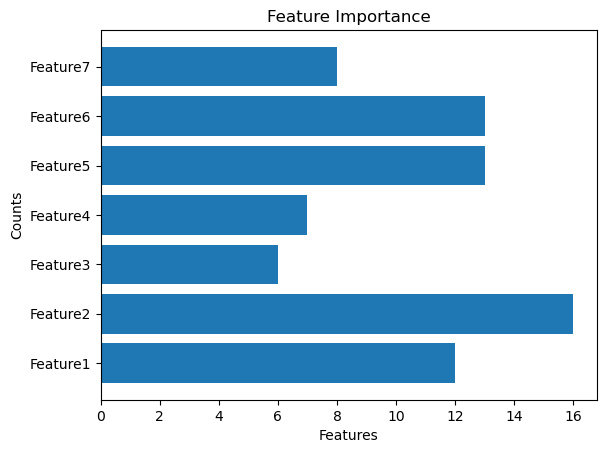

In [199]:
# For Q4
# Use simply counting to get the feature importance: dt_depth10.importance

labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']
_, counts = np.unique(dt_depth10.importance, return_counts=True)
plt.barh(labelList, counts)
plt.xlabel('Features')
plt.ylabel('Counts')
plt.title('Feature Importance')

plt.show()

# Questions for Random Rorest

In [200]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(1)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q5-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q5-1 n_estimators=10:  0.89125


In [201]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(1)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q5-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q5-1 n_estimators=50:  0.9025


In [202]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(1)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q6-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q6-1 max_features='sqrt':  0.89125


In [203]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(1)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q6-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q6-1 max_features='All':  0.8825


# Train your own model

In [204]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

In [205]:
df_train[["Feature1","Feature2","Feature3","Feature4","Feature5","Feature6","Feature7"]].corr()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7
Feature1,1.000000,0.386341,-0.004138,-0.296028,-0.576868,-0.770774,-0.420099
Feature2,0.386341,1.000000,-0.324435,-0.289485,-0.704998,-0.855532,-0.468541
Feature3,-0.004138,-0.324435,1.000000,0.168631,0.310731,0.234297,0.127865
Feature4,-0.296028,-0.289485,0.168631,1.000000,0.630952,0.331842,0.641411
Feature5,-0.576868,-0.704998,0.310731,0.630952,1.000000,0.776966,0.469712
Feature6,-0.770774,-0.855532,0.234297,0.331842,0.776966,1.000000,0.536559
Feature7,-0.420099,-0.468541,0.127865,0.641411,0.469712,0.536559,1.000000


In [206]:
df_val[["Feature1","Feature2","Feature3","Feature4","Feature5","Feature6","Feature7"]].corr()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7
Feature1,1.000000,0.399139,-0.033229,-0.327778,-0.549605,-0.761302,-0.445788
Feature2,0.399139,1.000000,-0.363908,-0.352929,-0.771125,-0.871342,-0.462257
Feature3,-0.033229,-0.363908,1.000000,0.197286,0.391074,0.282438,0.164315
Feature4,-0.327778,-0.352929,0.197286,1.000000,0.615878,0.405397,0.752217
Feature5,-0.549605,-0.771125,0.391074,0.615878,1.000000,0.825002,0.516993
Feature6,-0.761302,-0.871342,0.282438,0.405397,0.825002,1.000000,0.549088
Feature7,-0.445788,-0.462257,0.164315,0.752217,0.516993,0.549088,1.000000


In [207]:
df_test[["Feature1","Feature2","Feature3","Feature4","Feature5","Feature6","Feature7"]].corr()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7
Feature1,1.000000,0.417957,0.000479,-0.348071,-0.596061,-0.781198,-0.430903
Feature2,0.417957,1.000000,-0.295249,-0.309792,-0.711083,-0.865102,-0.456143
Feature3,0.000479,-0.295249,1.000000,0.172907,0.272652,0.203327,0.142244
Feature4,-0.348071,-0.309792,0.172907,1.000000,0.611806,0.364164,0.692280
Feature5,-0.596061,-0.711083,0.272652,0.611806,1.000000,0.790826,0.461448
Feature6,-0.781198,-0.865102,0.203327,0.364164,0.790826,1.000000,0.527943
Feature7,-0.430903,-0.456143,0.142244,0.692280,0.461448,0.527943,1.000000


In [208]:
df_train["Feature5_6"] = df_train["Feature5"] * df_train["Feature6"]
df_val["Feature5_6"] = df_val["Feature5"] * df_val["Feature6"]
df_test["Feature5_6"] = df_test["Feature5"] * df_test["Feature6"]

In [209]:
X_test = df_test[['Feature1', 'Feature2', 'Feature3','Feature4', 'Feature5', 'Feature6', 'Feature7',"Feature5_6"]].to_numpy()
X_train = df_train[['Feature1','Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7',"Feature5_6"]].to_numpy()
y_train = df_train["Target"].to_numpy(dtype=np.int64)
X_val = df_val[['Feature1', 'Feature2','Feature3','Feature4', 'Feature5', 'Feature6', 'Feature7',"Feature5_6"]].to_numpy()
y_val = df_val["Target"].to_numpy(dtype=np.int64)


In [210]:
np.random.seed(19)
model = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=20)
model.fit(X_train, y_train)
val_pred_acc = accuracy_score(y_val,  model.predict(X_val))
print("Validation Prediction Accurarcy: {}".format(val_pred_acc))

Validation Prediction Accurarcy: 0.905


In [211]:
val_pred_acc_prev = 0
np.random.seed(19)
# Build and train your model
for i in range(10):
    train_indices = df_val.sample(frac=0.1).index
    df_val_for_train = df_val.loc[train_indices]
    df_train_mixed = pd.concat([df_train,df_val_for_train])
    X_train = df_train_mixed[['Feature1','Feature2', "Feature3", 'Feature4', 'Feature5', 'Feature6', 'Feature7',"Feature5_6"]].to_numpy()
    y_train = df_train_mixed["Target"].to_numpy(dtype=np.int64)
    X_val = df_val[['Feature1', 'Feature2', "Feature3",'Feature4', 'Feature5', 'Feature6', 'Feature7',"Feature5_6"]].to_numpy()
    y_val = df_val["Target"].to_numpy(dtype=np.int64)
    model = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=20)
    model.fit(X_train, y_train)
    val_pred_acc = accuracy_score(y_val,  model.predict(X_val))
    if val_pred_acc > val_pred_acc_prev:
        val_pred_acc_prev = val_pred_acc
        print("Validation Prediction Accurarcy: {}".format(val_pred_acc))
        test_pred = model.predict(X_test)
        print("test_pred shape: ", test_pred.shape)
        df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
        df_test["Target"] = test_pred
        df_test.to_csv("311554060_prediction.csv")



Validation Prediction Accurarcy: 0.9125
test_pred shape:  (800,)
Validation Prediction Accurarcy: 0.91375
test_pred shape:  (800,)
Validation Prediction Accurarcy: 0.9175
test_pred shape:  (800,)
